### DADVI linear regression example

This is a really simple example of deterministic ADVI (DADVI) in action.

It's based on the notebook [here](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html).

We'll fit the model with both NUTS and DADVI and compare the result.

Of course, this isn't the greatest use case for DADVI, since the fit with NUTS is super-fast anyway, so there's no reason to do variational inference. But we can check it to make sure they give similar results on a simple model.

In [1]:
import pymc as pm

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import pymc as pm

from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.25.1


In [3]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")


In [4]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame({"x": x, "y": y})

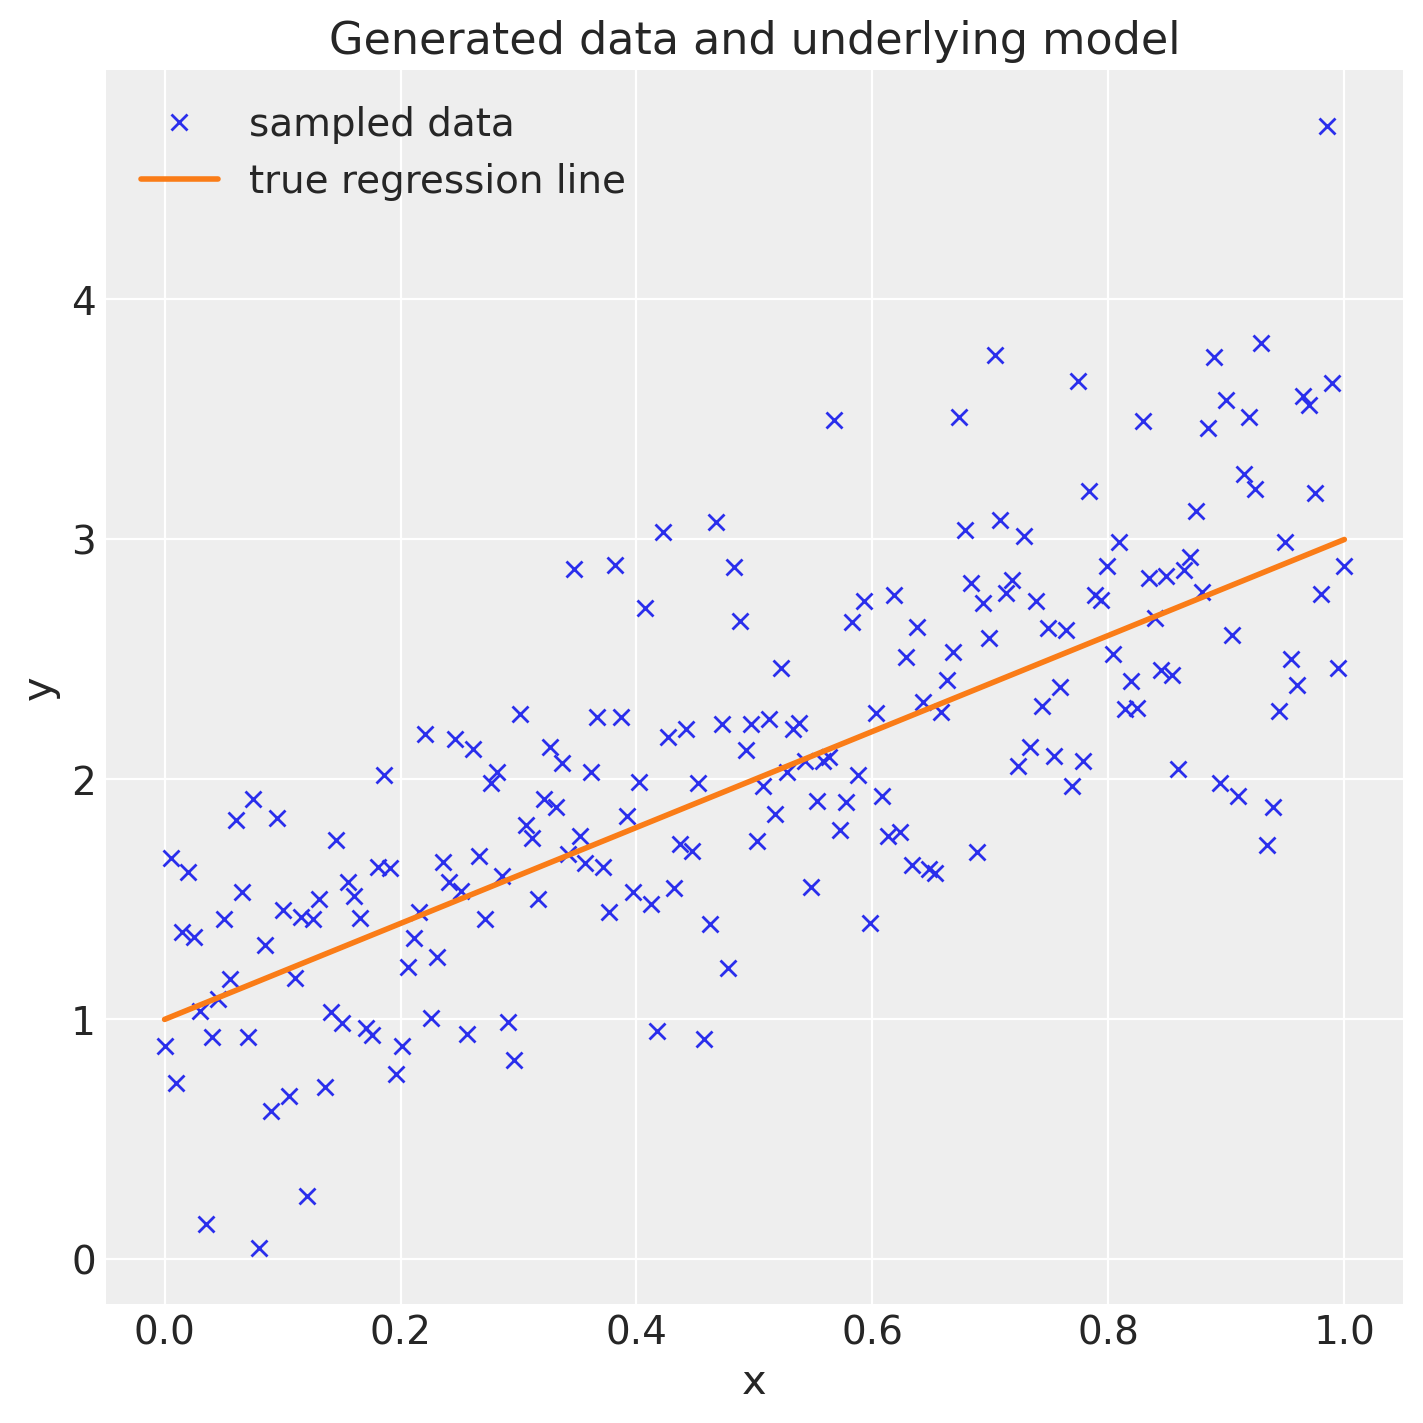

In [5]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [6]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta=10)
    intercept = Normal("Intercept", 0, sigma=20)
    slope = Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.


We've done inference with NUTS. Now we can try DADVI.

In [7]:
# This single import should be all that's needed
from pymc_extras.inference import fit_deterministic_advi

In [8]:
# We can fit DADVI now. It prints some progress of its convergence -- note we could change this
# to look different / remove it.
# Note that unlike regular ADVI, deterministic ADVI converges automatically. This is one of its key advantages.
with model:
    dadvi_res = fit_deterministic_advi()

Output()

In [9]:
# DADVI returns draws like MCMC
dadvi_res

<xarray.Dataset> Size: 32kB
Dimensions:    (chain: 1, draw: 1000)
Coordinates:
  * chain      (chain) int64 8B 0
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    Intercept  (chain, draw) float64 8kB 1.033 1.054 1.07 ... 1.035 1.038 1.069
    slope      (chain, draw) float64 8kB 2.009 2.046 2.063 ... 1.981 2.08 2.038
    sigma      (chain, draw) float64 8kB 0.475 0.4933 0.5824 ... 0.5156 0.5347
Attributes:
    created_at:                 2025-08-19T17:50:03.733248+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1

/var/folders/s_/l9wd4yls3mv1f4kkkz1xhhmm0000gn/T/ipykernel_26101/1628930406.py:18: UserWarning: The figure layout has changed to tight
  f.tight_layout()


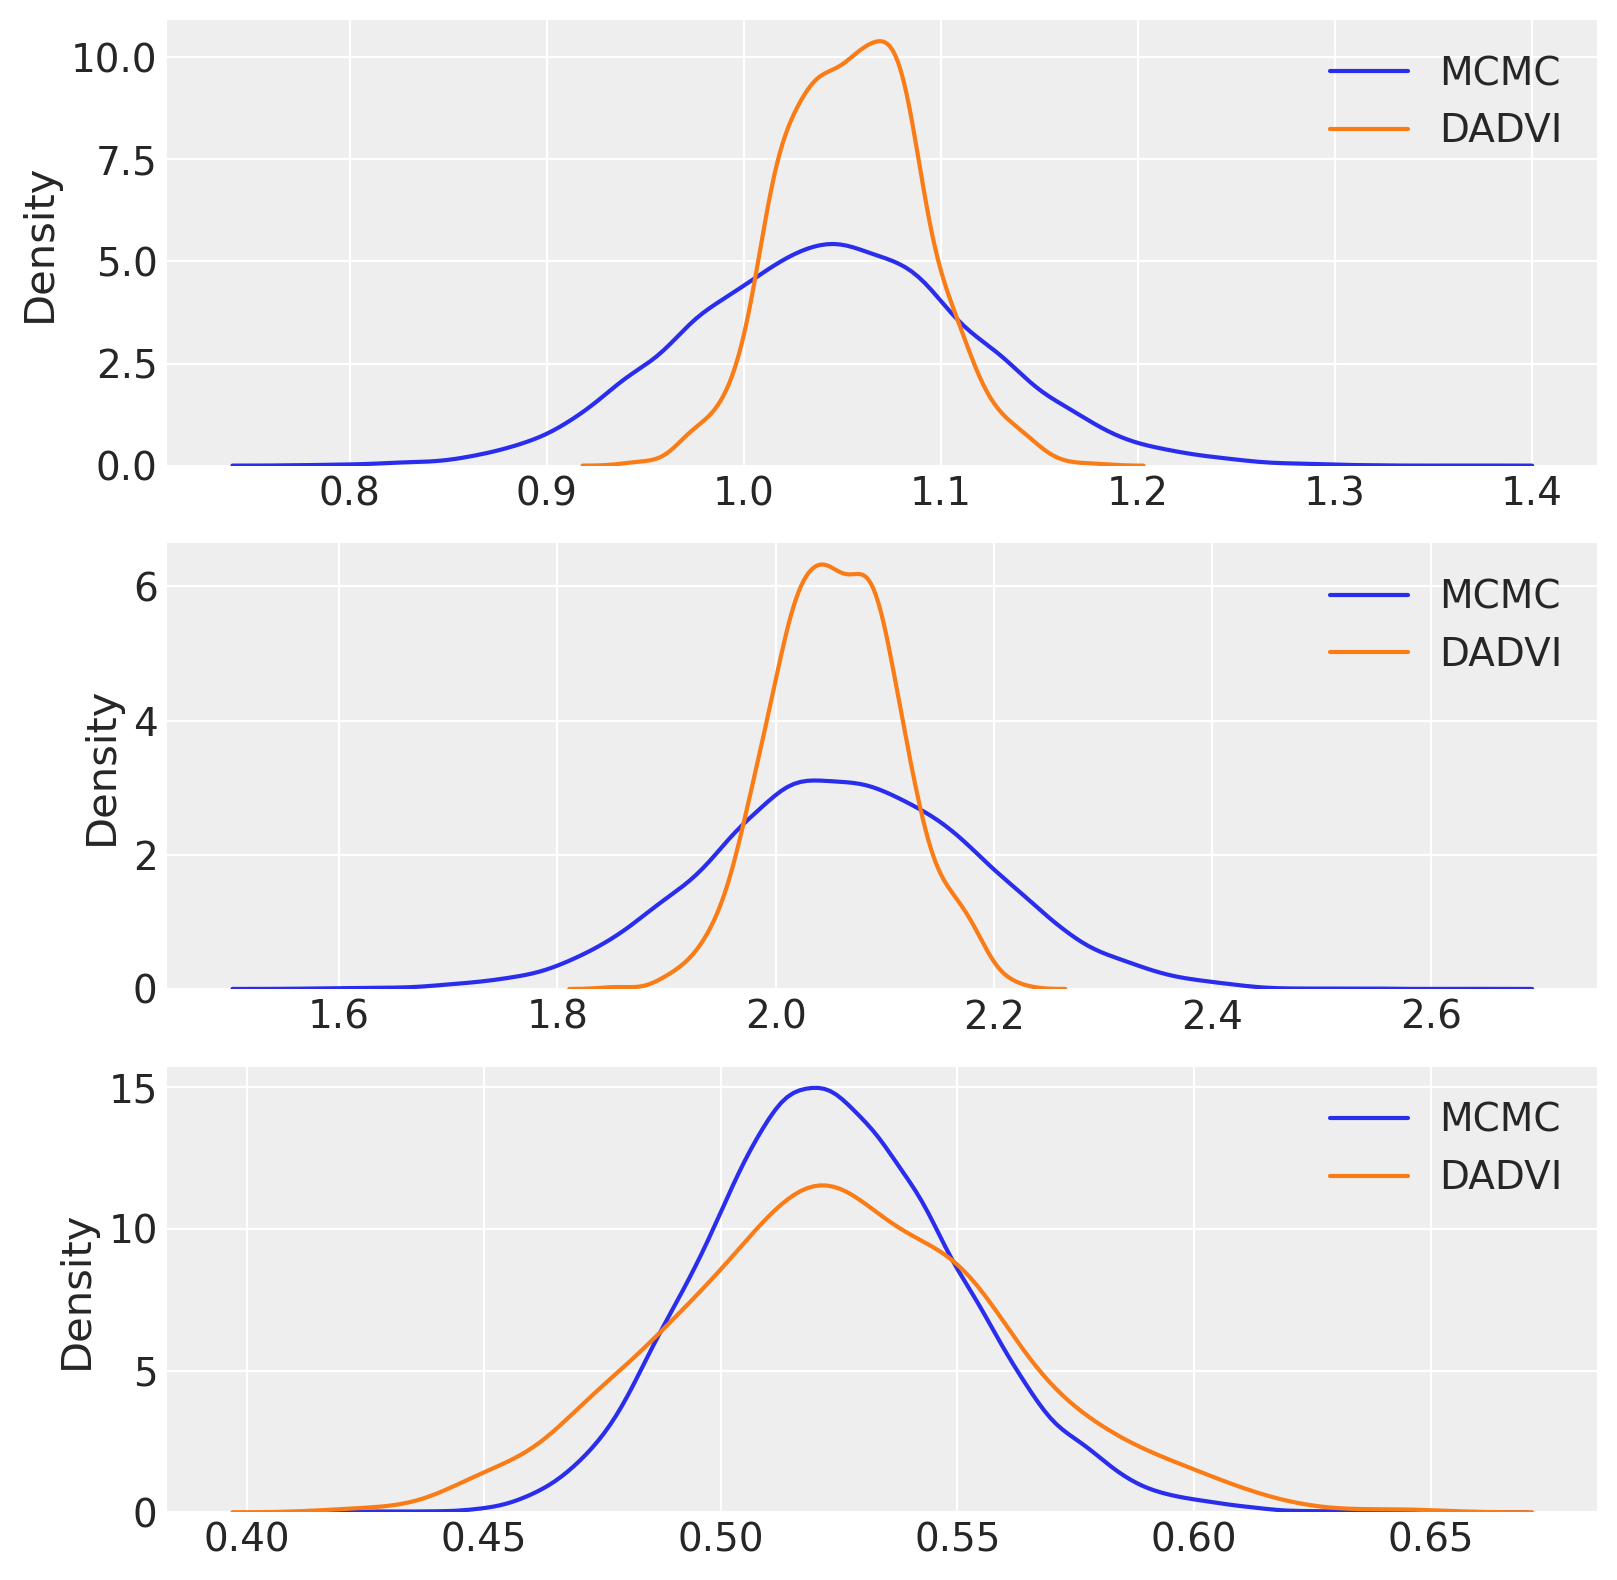

In [11]:
import seaborn as sns

f, ax = plt.subplots(3, 1)

sns.kdeplot(idata.posterior.Intercept.values.reshape(-1), ax=ax[0], label='MCMC')
sns.kdeplot(dadvi_res.Intercept.values.reshape(-1), ax=ax[0], label='DADVI')

sns.kdeplot(idata.posterior.slope.values.reshape(-1), ax=ax[1], label='MCMC')
sns.kdeplot(dadvi_res.slope.values.reshape(-1), ax=ax[1], label='DADVI')

sns.kdeplot(idata.posterior.sigma.values.reshape(-1), ax=ax[2], label='MCMC')
sns.kdeplot(dadvi_res.sigma.values.reshape(-1), ax=ax[2], label='DADVI')

for cur_ax in ax:
    cur_ax.legend()

f.set_size_inches(8, 8)
f.tight_layout()

We can see that the posteriors don't align perfectly. DADVI does a pretty good job matching the means, but underestimates the variance somewhat. However, often DADVI is much faster than MCMC, and so this is a tradeoff that can make sense.

Note that DADVI as explained in the [paper](https://jmlr.org/papers/volume25/23-1015/23-1015.pdf) has further tools to make variances more accurate, which we plan to add to PyMC later on. For now, its key advantage is that it converges automatically and reliably, removing one headache from ADVI.